# Using pyTorch implementation

In this second part, we use pyTorch's implementation of RNNs and LSTMs. Again, as we are focusing on understanding the model and library, we will keep using the IMDB dataset. The good news is training is much faster using pyTorch's implementations.

In [1]:
from functools import partial
from typing import Callable, Dict, Generator, List, Tuple

from datasets import load_dataset
import numpy as np
from sklearn.utils import shuffle
import torch
from torch import nn
from torchtext.vocab import vocab, Vocab
from torchtext.data.utils import get_tokenizer

from tqdm.auto import tqdm

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


## From dataset to batch inputs

You already know what to do here, it's the same as in the previous notebook.

In [4]:
dataset = load_dataset("imdb")
train_dataset = dataset["train"].train_test_split(test_size=0.2, seed=42)
test_df = dataset["test"]
train_df = train_dataset["train"]
valid_df = train_dataset["test"]
train_df.shape, valid_df.shape, test_df.shape

  0%|          | 0/3 [00:00<?, ?it/s]

((20000, 2), (5000, 2), (25000, 2))

In [5]:
def vectorize_text(
    text: str, vocabulary: Vocab, tokenizer: Callable[[str], List[str]]
) -> torch.Tensor:
    """
    Generate a tensor of vocabluary IDs for a given text.
    Args:
        text: the input text.
        vocabulary: a Vocab objects.
        tokenizer: a text tokenizer.
    Returns:
        A tensor of IDs (torch.long).
    """
    return torch.tensor(
        [vocabulary[token] for token in tokenizer(text)], dtype=torch.long
    )

In [6]:
from collections import Counter

tokenizer = get_tokenizer("basic_english")
vocabulary = vocab(
    Counter(token for text in tqdm(train_df["text"]) for token in tokenizer(text)),
    min_freq=10,
    specials=["<unk>", "<pad>"]
)
vocabulary.set_default_index(vocabulary["<unk>"])

text_pipeline = partial(vectorize_text, vocabulary=vocabulary, tokenizer=tokenizer)

  0%|          | 0/20000 [00:00<?, ?it/s]

In [7]:
X_train = [text_pipeline(text) for text in tqdm(train_df["text"])]
y_train = train_df["label"]
X_valid = [text_pipeline(text) for text in tqdm(valid_df["text"])]
y_valid = valid_df["label"]
X_test = [text_pipeline(text) for text in tqdm(test_df["text"])]
y_test = test_df["label"]

  0%|          | 0/20000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/25000 [00:00<?, ?it/s]

In [8]:
def data_generator(
    X: List[torch.tensor], y: List[int], pad_id: int, batch_size: int = 32
) -> Generator[Tuple[torch.Tensor, torch.Tensor], None, None]:
    """
    Yield batches from given input data and labels.
    Args:
        X: a list of tensor (input features).
        y: the corresponding labels.
        batch_size: the size of every batch [32].
    Returns:
        A tuple of tensors (features, labels).
    """
    X, y = shuffle(X, y)
    for i in range(0, len(X), batch_size):
        batch_X = X[i : i + batch_size]
        batch_y = y[i : i + batch_size]
        max_len = max([len(x) for x in batch_X])
        batch_X = torch.stack(
            [torch.cat([torch.ones(max_len - len(x), dtype=torch.long) * pad_id, x]) for x in batch_X]
        )
        yield batch_X, torch.tensor(batch_y, dtype=torch.long)

In [9]:
pad_token = "<pad>"
train_gen = lambda: data_generator(X_train, y_train, vocabulary[pad_token])
valid_gen = lambda: data_generator(X_valid, y_valid, vocabulary[pad_token])
test_gen = lambda: data_generator(X_test, y_test, vocabulary[pad_token])

In [10]:
device = "cuda:0" if torch.cuda.is_available() else "cpu"
device

'cuda:0'

## The classifier

The implementation behind shows how to use the [RNN](https://pytorch.org/docs/stable/generated/torch.nn.RNN.html) implementation provided by pyTorch to code a simple RNN.

In [11]:
class RNN(nn.Module):
    """A simple RNN module with word embeddings.
    """
    def __init__(self, vocab_size: int, embed_size: int, hidden_size: int, n_layers: int, n_outputs: int) -> None:
        """
        Args:
            vocab_size: vocabulary size.
            embed_size: embedding dimensions.
            hidden_size: hidden layer size.
            n_layers: the number of layers.
            n_outputs: the number of output classes.
        """
        super().__init__()
        self.vocab_size = vocab_size
        self.embed_size = embed_size
        self.hidden_size = hidden_size
        self.n_layers = n_layers
        self.n_outputs = n_outputs


        # The word embedding layer.
        self.embed = nn.Embedding(self.vocab_size, self.embed_size)
        # The RNN
        self.rnn = nn.RNN(
            input_size = self.embed_size,
            hidden_size = self.hidden_size,
            num_layers = self.n_layers,
            batch_first = True, # Changes the order of dimension to put the batches first.
        )
        # A fully connected layer to project the RNN's output to only one output used for classification.
        self.fc = nn.Linear(self.hidden_size, self.n_outputs)

    def forward(self, X: torch.Tensor) -> torch.Tensor:
        """Function called when the model is called with data as input.
        Args:
            X: the input tensor of dimensions batch_size, sequence length, vocab size (actually just an int).
        Returns:
            The resulting tensor of dimension batch_size, sequence length, output dimensions.
        """
        h0 = torch.zeros(self.n_layers, X.size(0), self.hidden_size).to(device)

        out = self.embed(X)
        # out contains the output layer of all words in the sequence.
        # First dim is batch, second the word in the sequence, third is the vector itself.
        # The second output value is the last vector of all intermediate layer.
        # Only use it if you want to access the intermediate layer values of a
        # multilayer model.
        out, _ = self.rnn(out, h0)
        # Getting the last value only.
        out = out[:, -1, :]
    
        # Linear projection.
        out = self.fc(out)

        return out

## Training (1 point)

**\[1 point\]** Code the training function.
* Note that we are using a function, as we will use it on several models here.
* The RNN implementation of pyTorch doesn't need to be manually looped. As commented in the `forward` function above, `out` contains the ouptut layer for all words in the sequence, and taking its last value is what we needed.

In [12]:
import copy


def train(
    model: nn.Module,
    criterion: Callable,
    optimizer: torch.optim.Optimizer,
    n_epochs: int,
    train_gen: Callable,
    valid_gen: Callable,
) -> Tuple[nn.Module, List[float], List[float]]:
    """Train a model using a batch gradient descent.
    Args:
        model: a class inheriting from nn.Module.
        criterion: a loss criterion.
        optimizer: an optimizer (e.g. Adam, RMSprop, ...).
        n_epochs: the number of training epochs.
        train_gen: a callable function returing a batch (data, labels).
        valid_gen: a callable function returing a batch (data, labels).
    Returns:
        A tuple:[best_model (by validation loss), training losses, validation losses].
    """
    best_model = copy.deepcopy(model)
    best_loss = float("inf")
    train_losses = []
    valid_losses = []
    for _ in tqdm(range(n_epochs)):
        model.train()
        train_loss = 0.0
        for X, y in train_gen():
            X, y = X.to(device), y.to(device).float()
            optimizer.zero_grad()
            y_pred = model(X)
            loss = criterion(y_pred.squeeze(), y)
            loss.backward()
            optimizer.step()
            train_loss += loss.item() * X.size(0)
        train_loss /= len(X_train)
        train_losses.append(train_loss)

        model.eval()
        valid_loss = 0.0
        with torch.no_grad():
            for X, y in valid_gen():
                X, y = X.to(device), y.to(device).float()
                y_pred = model(X)
                loss = criterion(y_pred.squeeze(), y)
                valid_loss += loss.item() * X.size(0)
            valid_loss /= len(X_valid)
            valid_losses.append(valid_loss)
            if valid_loss < best_loss:
                best_loss = valid_loss
                best_model = copy.deepcopy(model)
    return best_model, train_losses, valid_losses

In [13]:
model = RNN(len(vocabulary), 32, 64, 1, 1).to(device)
criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters())

In [14]:
best_model, train_losses, valid_losses = train(model, criterion, optimizer, 20, train_gen, valid_gen)

  0%|          | 0/20 [00:00<?, ?it/s]

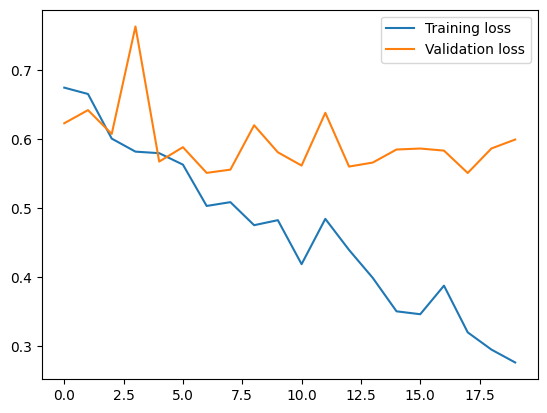

In [15]:
from matplotlib import pyplot as plt


plt.plot(train_losses, label="Training loss")
plt.plot(valid_losses, label="Validation loss")
plt.legend()

## Do the following (5 points)
* **\[1 point\]** Add an accuracy function and report the accuracy of the training, validation, and test set.
* **\[2 points\]** Create an LSTM class which uses an LSTM instead of an RNN. Compare its results with the RNN.
  * Look at the [LSTM documentation of pyTorch](https://pytorch.org/docs/stable/generated/torch.nn.LSTM.html).
* **\[1 point\]** Implement a function which takes any text and returns the model's prediction.
    * The function should have a string as input and return a class (0 or 1) and its confidence (between 0 and 1).
* **\[Bonus\]** Create a bidirectional LSTM (BiLSTM) class to classify your sentences. Report the accuracy on the training and test data.
    * **Beware of the behaviour of the output layer.** For a bidirectional LSTM, the output layer concatenates the forward and backward vector of each token. But we need to use the forward output of the last token, and the backward output of the first token, as input to our output layer.
* **\[1 point\]** With your best classifier, look at two wrongly classified examples on the test set. Try explaining why the model was wrong.
* **\[Bonus\]** Try finding better hyperparameters (dimensions, number of layers, ...). Document your experiments and results.

In [16]:
# Add an accuracy function and report the accuracy of the training, validation, and test set.
def accuracy(model: nn.Module, data_gen: Callable) -> float:
    """Compute the accuracy of a model.
    Args:
        model: a class inheriting from nn.Module.
        data_gen: a callable function returing a batch (data, labels).
    Returns:
        The accuracy of the model.
    """
    model.eval()
    with torch.no_grad():
        correct = 0
        total = 0
        for X, y in data_gen():
            X, y = X.to(device), y.to(device).float()
            y_pred = model(X)
            y_pred = torch.sigmoid(y_pred)
            y_pred = torch.round(y_pred)
            correct += (y_pred.squeeze() == y).sum().item()
            total += y.size(0)
    return correct / total

In [17]:
print(f"Training accuracy: {accuracy(best_model, train_gen):.2f}")
print(f"Validation accuracy: {accuracy(best_model, valid_gen):.2f}")
print(f"Test accuracy: {accuracy(best_model, test_gen):.2f}")

/opt/conda/lib/python3.10/site-packages/torch/nn/modules/rnn.py:509: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at /usr/local/src/pytorch/aten/src/ATen/native/cudnn/RNN.cpp:982.)
  result = _VF.rnn_tanh(input, hx, self._flat_weights, self.bias, self.num_layers,


Training accuracy: 0.88
Validation accuracy: 0.77
Test accuracy: 0.77


In [18]:
# Create an LSTM class which uses an LSTM instead of an RNN. Compare its results with the RNN.
class LSTM(nn.Module):
    def __init__(
        self,
        vocab_size: int,
        embed_size: int,
        hidden_size: int,
        n_layers: int,
        n_outputs: int,
    ):
        """Initialize a LSTM.
        Args:
            vocab_size: the size of the vocabulary.
            embed_size: embedding dimensions.
            hidden_size: hidden layer size.
            n_layers: the number of layers.
            n_outputs: the number of output classes.
        """
        super().__init__()
        self.vocab_size = vocab_size
        self.embed_size = embed_size
        self.hidden_size = hidden_size
        self.n_layers = n_layers
        self.n_outputs = n_outputs


        # The word embedding layer.
        self.embed = nn.Embedding(self.vocab_size, self.embed_size)
        # The LSTM
        self.lstm = nn.LSTM(
            input_size = self.embed_size,
            hidden_size = self.hidden_size,
            num_layers = self.n_layers,
            batch_first = True, # Changes the order of dimension to put the batches first.
        )
        # A fully connected layer to project the RNN's output to only one output used for classification.
        self.fc = nn.Linear(self.hidden_size, self.n_outputs)

    def forward(self, X: torch.Tensor) -> torch.Tensor:
        """Forward pass of the LSTM.
        Args:
            X: the input data.
        Returns:
            The output of the LSTM.
        """
        # Embedding the input.
        out = self.embed(X)
        # LSTM
        out, _ = self.lstm(out)
        # Getting the last value only.
        out = out[:, -1, :]
    
        # Linear projection.
        out = self.fc(out)

        return out

  0%|          | 0/20 [00:00<?, ?it/s]

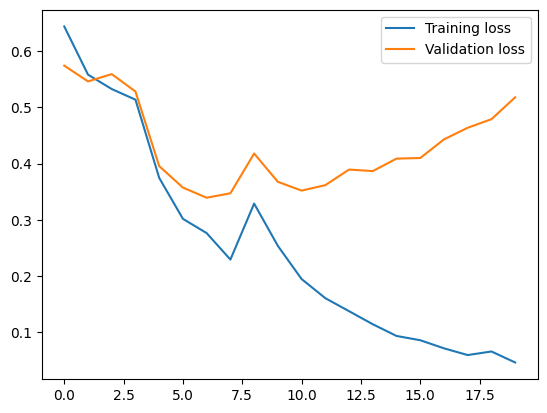

In [19]:
# Compare its results with the RNN.
model = LSTM(len(vocabulary), 32, 64, 1, 1).to(device)
criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters())

best_model_lstm, train_losses, valid_losses = train(model, criterion, optimizer, 20, train_gen, valid_gen)

plt.plot(train_losses, label="Training loss")
plt.plot(valid_losses, label="Validation loss")
plt.legend()

In [20]:
print(f"Training accuracy: {accuracy(best_model_lstm, train_gen):.2f}")
print(f"Validation accuracy: {accuracy(best_model_lstm, valid_gen):.2f}")
print(f"Test accuracy: {accuracy(best_model_lstm, test_gen):.2f}")

/opt/conda/lib/python3.10/site-packages/torch/nn/modules/rnn.py:812: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at /usr/local/src/pytorch/aten/src/ATen/native/cudnn/RNN.cpp:982.)
  result = _VF.lstm(input, hx, self._flat_weights, self.bias, self.num_layers,


Training accuracy: 0.92
Validation accuracy: 0.86
Test accuracy: 0.85


In [21]:
# Implement a function which takes any text and returns the model's prediction.
#     * The function should have a string as input and return a class (0 or 1) and its confidence (between 0 and 1).

def text_to_int(text: str, vocabulary: Dict[str, int]) -> List[int]:
    """Convert a text to a list of integers.
    Args:
        text: the text to convert.
        vocabulary: the vocabulary to use.
    Returns:
        The list of integers.
    """
    return [vocabulary[c] for c in text]

def predict(model: nn.Module, text: str) -> Tuple[int, float]:
    model.eval()
    with torch.no_grad():
        # Convert the text to a tensor.
        X = torch.tensor([text_to_int(text, vocabulary)]).to(device)
        # Forward pass.
        y_pred = model(X)
        y_pred = torch.sigmoid(y_pred)
        y_pred = torch.round(y_pred)
        # Get the class and the confidence.
        return int(y_pred.item()), y_pred.item()

In [33]:
# Test the function on a few examples.
print(predict(best_model_lstm, "I love this movie!"))
print(predict(best_model_lstm, "I hate this movie!"))
print(predict(best_model_lstm, "This movie is great!"))
print(predict(best_model_lstm, "This movie is bad!"))
print(predict(best_model_lstm, "What to think about this movie?"))

(0, 0.0)
(0, 0.0)
(1, 1.0)
(0, 0.0)
(0, 0.0)


In [30]:
# Create a bidirectional LSTM (BiLSTM) class to classify your sentences. Report the accuracy on the training and test data.
#     - Beware of the behaviour of the output layer. For a bidirectional LSTM, the output layer concatenates the forward and backward vector of each token. But we need to use the forward output of the last token, and the backward output of the first token, as input to our output layer.

class BiLSTM(nn.Module):
    
    def __init__(
        self,
        vocab_size: int,
        embed_size: int,
        hidden_size: int,
        n_layers: int,
        n_outputs: int,
    ):
        """Initialize a BiLSTM.
        Args:
            vocab_size: the size of the vocabulary.
            embed_size: embedding dimensions.
            hidden_size: hidden layer size.
            n_layers: the number of layers.
            n_outputs: the number of output classes.
        """
        super().__init__()
        self.vocab_size = vocab_size
        self.embed_size = embed_size
        self.hidden_size = hidden_size
        self.n_layers = n_layers
        self.n_outputs = n_outputs

        # The word embedding layer.
        self.embed = nn.Embedding(self.vocab_size, self.embed_size)
        # The BiLSTM
        self.lstm = nn.LSTM(
            input_size = self.embed_size,
            hidden_size = self.hidden_size,
            num_layers = self.n_layers,
            batch_first = True, # Changes the order of dimension to put the batches first.
            bidirectional = True,
        )
        # A fully connected layer to project the RNN's output to only one output used for classification.
        self.fc = nn.Linear(self.hidden_size * 2, self.n_outputs)

    def forward(self, X: torch.Tensor) -> torch.Tensor:
        """Forward pass of the BiLSTM.
        Args:
            X: the input data.
        Returns:
            The output of the BiLSTM.
        """
        # Embedding the input.
        out = self.embed(X)
        # BiLSTM
        out, _ = self.lstm(out)
        # Getting the last value only.
        out = out[:, -1, :]
    
        # Linear projection.
        out = self.fc(out)

        return out

  0%|          | 0/20 [00:00<?, ?it/s]

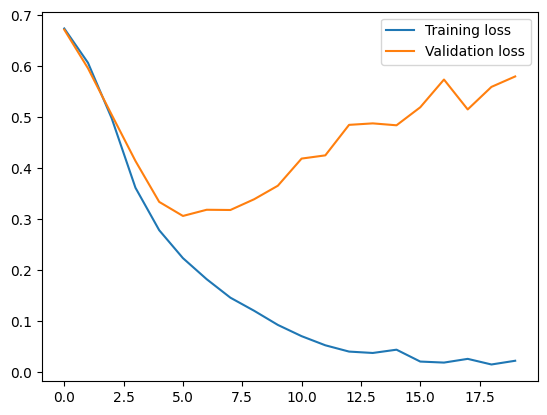

In [31]:
model = BiLSTM(len(vocabulary), 32, 64, 1, 1).to(device)
criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters())

best_model_bilstm, train_losses, valid_losses = train(model, criterion, optimizer, 20, train_gen, valid_gen)

plt.plot(train_losses, label="Training loss")
plt.plot(valid_losses, label="Validation loss")
plt.legend()

In [32]:
print(f"Training accuracy: {accuracy(best_model_bilstm, train_gen):.2f}")
print(f"Validation accuracy: {accuracy(best_model_bilstm, valid_gen):.2f}")
print(f"Test accuracy: {accuracy(best_model_bilstm, test_gen):.2f}")

Training accuracy: 0.94
Validation accuracy: 0.87
Test accuracy: 0.86


In [47]:
# look at two wrongly classified examples on the test set. Try explaining why the model was wrong.
#     - You can use the predict function you implemented earlier.

def get_wrong_predictions(model: nn.Module, generator: Callable) -> List[Tuple[str, int, float]]:
    """Get the wrong predictions of a model.
    Args:
        model: the model to use.
        generator: the generator to use.
    Returns:
        The wrong predictions.
    """
    wrong_predictions = []
    for X, y in generator():
        X = X.to(device)
        y = y.to(device)
        y_pred = model(X)
        y_pred = torch.sigmoid(y_pred)
        y_pred = torch.round(y_pred)
        for i in range(len(y)):
            if y_pred[i] != y[i]:
                wrong_predictions.append((" ".join(filter(lambda t: t != pad_token, vocabulary.lookup_tokens(X[i].tolist()))), int(y[i]), y_pred[i].item()))
    return wrong_predictions

wrong_predictions = get_wrong_predictions(best_model_bilstm, test_gen)

for text, y, y_pred in wrong_predictions[:2]:
    print(f"Text: {text}")
    print(f"True class: {y}")
    print(f"Predicted class: {y_pred}")
    print()

/opt/conda/lib/python3.10/site-packages/torch/nn/modules/rnn.py:812: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at /usr/local/src/pytorch/aten/src/ATen/native/cudnn/RNN.cpp:982.)
  result = _VF.lstm(input, hx, self._flat_weights, self.bias, self.num_layers,


Text: hello everyone , all i have to say is that human traffic and all of its characters are so real its funny . i live in australia ( melbourne ) and i ' m finally out of the <unk> and staying out all weekend lifestyle . this movie explains everything that is currently going on in the world . so exactly that i cant stop watching it . . . . i used to be exactly like <unk> , so my friends said and i hadn ' t even seen the movie . . i left the weekend partying behind about 3 months ago after 4 years of intense partying to change my life around . . i was at a dvd store when i saw human traffic and i remember my old friends going on an on about it , so i bought it to see what all the fuss was about . . i was so into it i watched it 4 times in a row because i couldn ' t believe that someone had made a movie that explains everything to a t . anyways this movie is by far the best and funniest movie i have ever seen . . its funny because its so truthful in everything that goes on in the movie 

In [48]:
torch.save(best_model, "best_model_torch.pt")
torch.save(best_model_lstm, "best_model_lstm.pt")
torch.save(best_model_bilstm, "best_model_bilstm.pt")